In [9]:



# Imports
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2,RFE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble._bagging import BaggingClassifier
from sklearn.ensemble._forest import ExtraTreesClassifier

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble._bagging import BaggingClassifier
from sklearn.metrics import confusion_matrix, fbeta_score

from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, count
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient, ClassificationMoment, Moment, DemographicParity, GridSearch
from fairlearn.metrics import equalized_odds_difference, equalized_odds_ratio, false_negative_rate_difference, false_positive_rate_difference, true_positive_rate_difference, true_negative_rate_difference, demographic_parity_ratio, demographic_parity_difference

# Suppress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [10]:
# Setting parameters

alpha = 0.1 # Statistical significance for chi2 test. 
k = 3 # Minimum number of feature selection method selecting a given feature. 

models_to_train = [
     LogisticRegression, 
    RandomForestClassifier, 
     DecisionTreeClassifier, 
     #XGBClassifier, 
    BaggingClassifier
]


unfairness_metrics = [
    selection_rate, 
    fbeta_score, 
    equalized_odds_difference, 
    equalized_odds_ratio
]
model_evaulation = [
    accuracy_score, 
    recall_score, 
    precision_score, 
    f1_score 
]

demographic_features = [
    'RACE', 
    'FEMALE', 
    'PAY1_X'
    'ZIPINC_QRTL', 
    'AGE'
]

# Choose the appropriate variable for selected features depending on the dataset being used. 
# Keep all categorical features numeric. 

output_path ='data.csv'


# Feature Selection

In [17]:
from pandas.core.groupby.generic import DataFrame
from pandas.io.formats.format import DataFrameRenderer
from sklearn.model_selection import train_test_split


def clean_and_preprocess(df, columns_to_select, select_all=False):

    X=df[all_features_arizona]
    y=df['LOS_category']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test, X, y, df


In [18]:
X_train, X_test, y_train, y_test, X, y, df = clean_and_preprocess(df, all_features_arizona)

# Chi sq

In [1]:
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd

# Select the top 46 features based on the chi-squared test
chi_selector = SelectKBest(chi2, k=91)
chi_selector.fit(X_train, y_train)

X_train_selected = chi_selector.transform(X_train)
X_test_selected = chi_selector.transform(X_test)

# Get the important scores for each variable
chi_scores = chi_selector.scores_

# Create a data frame that contains the variable names and their corresponding important scores
df_chi_scores = pd.DataFrame({'Variable': X.columns, 'Score': chi_scores})

# Calculate the mean, median, standard deviation, minimum, and maximum important score for each variable
mean_score_chi = df_chi_scores['Score'].mean()
median_score_chi = df_chi_scores['Score'].median()
std_score_chi = df_chi_scores['Score'].std()
min_score_chi = df_chi_scores['Score'].min()
max_score_chi = df_chi_scores['Score'].max()

# Print the statistics for important scores
print(f"Mean important score: {mean_score_chi}")
print(f"Median important score: {median_score_chi}")
print(f"Standard deviation of important score: {std_score_chi}")
print(f"Minimum important score: {min_score_chi}")
print(f"Maximum important score: {max_score_chi}")

# Rank the variables based on their mean important score in descending order
df_rankings = df_chi_scores.sort_values(by='Score', ascending=False)
print(df_rankings)



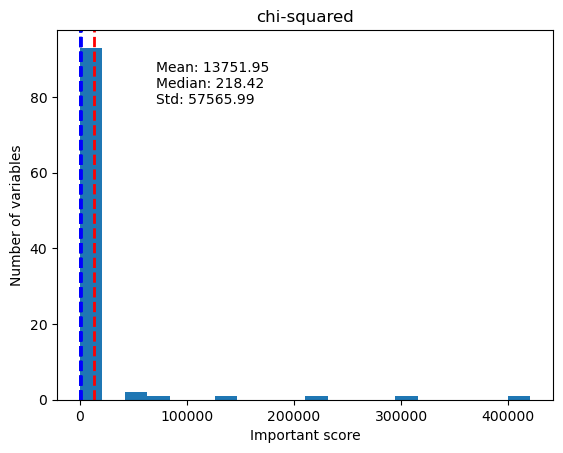

In [20]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt

# Define the number of top features to select
num_top_features = 91

# Define the feature selection methods to use
feature_selectors = [('chi-squared', SelectKBest(chi2, k=num_top_features))]

# Create a dictionary to hold the scores for each feature selection method
scores_dict = {}

# Loop through each feature selection method and calculate the scores
for selector_name, selector in feature_selectors:
    selector.fit(X_train, y_train)
    scores = selector.scores_
    scores_dict[selector_name] = scores

# Create a data frame that contains the variable names and their corresponding scores for each feature selection method
df_scores = pd.DataFrame(X.columns, columns=['Variable'])
for selector_name in scores_dict:
    df_scores[selector_name] = scores_dict[selector_name]

# Get the quartile points
quartiles = df_scores['chi-squared'].quantile([0, 0.25, 0.5, 0.75, 1]).values

# Plot histograms of important scores for each feature selection method
for selector_name in scores_dict:
    fig, ax = plt.subplots()
    ax.hist(df_scores[selector_name], bins=20)
    ax.set_title(selector_name)
    ax.set_xlabel('Important score')
    ax.set_ylabel('Number of variables')
    ax.axvline(df_scores[selector_name].mean(), color='red', linestyle='dashed', linewidth=2)
    ax.axvline(df_scores[selector_name].median(), color='green', linestyle='dashed', linewidth=2)
    ax.axvline(quartiles[1], color='blue', linestyle='dashed', linewidth=2)
    ax.axvline(quartiles[2], color='blue', linestyle='dashed', linewidth=2)
    ax.axvline(quartiles[3], color='blue', linestyle='dashed', linewidth=2)
    ax.text(df_scores[selector_name].mean() + df_scores[selector_name].std(), ax.get_ylim()[1]*0.8,
             f"Mean: {df_scores[selector_name].mean():.2f}\nMedian: {df_scores[selector_name].median():.2f}\nStd: {df_scores[selector_name].std():.2f}")
    plt.show()


In [53]:
# Get the features above mean
above_mean = df_scores[df_scores['chi-squared'] > df_scores['chi-squared'].mean()]

# Get the features below mean
below_mean = df_scores[df_scores['chi-squared'] <= df_scores['chi-squared'].mean()]


In [55]:
# Get the percentage of features above mean
perc_above_mean = len(above_mean) / len(df_scores) * 100
print(f"Percentage of features above mean: {perc_above_mean:.2f}%")


Percentage of features above mean: 7.07%


In [57]:
# Get the quartiles
quartiles = df_scores['chi-squared'].quantile([0, 0.25, 0.5, 0.75, 1]).values
print("Quartiles:", quartiles)

# Find the number of features in each quartile
q1_count = len(df_scores[(df_scores['chi-squared'] >= quartiles[0]) & (df_scores['chi-squared'] < quartiles[1])])
q2_count = len(df_scores[(df_scores['chi-squared'] >= quartiles[1]) & (df_scores['chi-squared'] < quartiles[2])])
q3_count = len(df_scores[(df_scores['chi-squared'] >= quartiles[2]) & (df_scores['chi-squared'] < quartiles[3])])
q4_count = len(df_scores[(df_scores['chi-squared'] >= quartiles[3]) & (df_scores['chi-squared'] <= quartiles[4])])

# Calculate the percentage of features in each quartile
total_features = len(df_scores)
q1_percent = q1_count / total_features * 100
q2_percent = q2_count / total_features * 100
q3_percent = q3_count / total_features * 100
q4_percent = q4_count / total_features * 100

# Print the number and percentage of features in each quartile
print(f"{q1_count} features ({q1_percent:.2f}%) lie within 1Q")
print(f"{q2_count} features ({q2_percent:.2f}%) lie within 2Q")
print(f"{q3_count} features ({q3_percent:.2f}%) lie within 3Q")
print(f"{q4_count} features ({q4_percent:.2f}%) lie within 4Q")


Quartiles: [4.63469345e-03 2.08914720e+01 2.15267866e+02 1.43767419e+03
 4.20587186e+05]
25 features (25.25%) lie within 1Q
24 features (24.24%) lie within 2Q
25 features (25.25%) lie within 3Q
25 features (25.25%) lie within 4Q


In [24]:
above_median_chi=df_rankings[df_rankings["Score"]>=df_rankings["Score"].median()].sort_values(by='Score', ascending=False)

In [1]:
above_mean_chi=df_rankings[df_rankings["Score"]>=df_rankings["Score"].mean()].sort_values(by='Score', ascending=False)


In [25]:
df_rankings = df_rankings.rename(columns={'Score': 'Score_chi2'})


### RFE

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression model
model = LogisticRegression()

# Use RFE to select the best features
rfe = RFE(model)#, #n_features_to_select= 90)
rfe = rfe.fit(X, y)

# Print the selected features
print("Selected Features:", X.columns[rfe.support_])

# Get important scores for each variable using RFE
rfe_scores = rfe.ranking_

# Create a data frame that contains the variable names and their corresponding important scores for RFE
df_rfe_scores = pd.DataFrame({'Variable': X.columns, 'Score': rfe_scores})

# Calculate the mean, median, standard deviation, minimum, and maximum important score for each variable for RFE
mean_score_rfe = df_rfe_scores['Score'].mean()
median_score_rfe = df_rfe_scores['Score'].median()
std_score_rfe = df_rfe_scores['Score'].std()
min_score_rfe = df_rfe_scores['Score'].min()
max_score_rfe = df_rfe_scores['Score'].max()

# Print the statistics for important scores for RFE
print(f"Mean important score: {mean_score_rfe}")
print(f"Median important score: {median_score_rfe}")
print(f"Standard deviation of important score: {std_score_rfe}")
print(f"Minimum important score: {min_score_rfe}")
print(f"Maximum important score: {max_score_rfe}")

# Rank the variables based on their mean important score in descending order for RFE
df_rankings3 = df_rfe_scores.sort_values(by='Score', ascending=False)



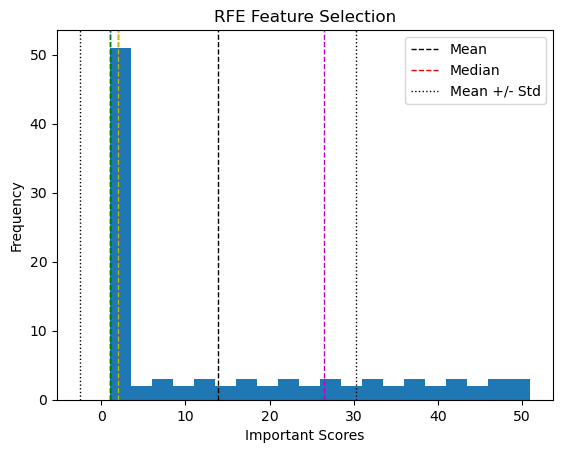

In [72]:
# Plot histogram of important scores for RFE
def plot_hist(df_scores, title):
    fig, ax = plt.subplots()
    ax.hist(df_scores['Score'], bins=20)
    ax.axvline(df_scores['Score'].mean(), color='k', linestyle='dashed', linewidth=1)
    ax.axvline(df_scores['Score'].median(), color='r', linestyle='dashed', linewidth=1)
    ax.axvline(df_scores['Score'].mean() - df_scores['Score'].std(), color='k', linestyle='dotted', linewidth=1)
    ax.axvline(df_scores['Score'].mean() + df_scores['Score'].std(), color='k', linestyle='dotted', linewidth=1)
    ax.set_xlabel('Important Scores')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.legend(['Mean', 'Median', 'Mean +/- Std'])
    
    # Calculate the quartiles
    quartiles = df_scores['Score'].quantile([0, 0.25, 0.5, 0.75, 1]).values
    ax.axvline(quartiles[0], color='b', linestyle='dashed', linewidth=1)
    ax.axvline(quartiles[1], color='g', linestyle='dashed', linewidth=1)
    ax.axvline(quartiles[2], color='y', linestyle='dashed', linewidth=1)
    ax.axvline(quartiles[3], color='m', linestyle='dashed', linewidth=1)

# Call the plot_hist function for RFE feature selection method
plot_hist(df_rfe_scores, 'RFE Feature Selection')



In [2]:
# Calculate above and below mean features
above_mean = df_rfe_scores[df_rfe_scores['Score'] > mean_score_rfe]['Variable'].tolist()
below_mean = df_rfe_scores[df_rfe_scores['Score'] < mean_score_rfe]['Variable'].tolist()
num_above_mean = len(above_mean)
num_below_mean = len(below_mean)
total_num_features = len(df_rfe_scores)
perc_above_mean = (num_above_mean / total_num_features) * 100
perc_below_mean = (num_below_mean / total_num_features) * 100

# Print the results
print(f"Number of features above mean: {num_above_mean} ({perc_above_mean:.2f}%)")
print(f"Number of features below mean: {num_below_mean} ({perc_below_mean:.2f}%)")

# Print the list of features above mean and below mean
print("Features above mean:", above_mean)
print("Features below mean:", below_mean)


In [3]:
# Find the number of features in each quartile
num_quartiles = 4
quartiles = np.linspace(0, 1, num_quartiles+1)
quartile_counts = np.zeros(num_quartiles, dtype=int)
for i in range(num_quartiles):
    q_lower = df_rfe_scores['Score'].quantile(quartiles[i])
    q_upper = df_rfe_scores['Score'].quantile(quartiles[i+1])
    quartile_counts[i] = len(df_rfe_scores[(df_rfe_scores['Score'] >= q_lower) & (df_rfe_scores['Score'] <= q_upper)])

# Calculate the total number of features and percentages in each quartile
total_num_features = len(df_rfe_scores)
perc_quartiles = 100 * quartile_counts / total_num_features

# Print the number of features in each quartile and the percentage of features in each quartile
for i in range(num_quartiles):
    print(f"Number of features in quartile {i+1}: {quartile_counts[i]} ({perc_quartiles[i]:.2f}%)")

# Print the features in each quartile
for i in range(num_quartiles):
    q_lower = df_rfe_scores['Score'].quantile(quartiles[i])
    q_upper = df_rfe_scores['Score'].quantile(quartiles[i+1])
    features = df_rfe_scores[(df_rfe_scores['Score'] >= q_lower) & (df_rfe_scores['Score'] <= q_upper)]['Variable'].values
    print(f"Features in quartile {i+1}: {features}")


In [4]:
df_rankings3.sort_values(by='Score', ascending=False)

In [5]:
df_rankings3["Score"].rank(ascending=False)

In [30]:
above_median_rfe=df_rankings3[df_rankings3["Score"]>=df_rankings3["Score"].median()].sort_values(by='Score', ascending=False)

In [79]:
above_mean_rfe= df_rankings3[df_rankings3["Score"]>=df_rankings3["Score"].mean()].sort_values(by='Score', ascending=False)

In [31]:
df_rankings3 = df_rankings3.rename(columns={'Score': 'Score_rfe'})


## Lasso

In [6]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

# Logistic Regression with L1 regularization
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1", solver="liblinear"), max_features=91)
embeded_lr_selector.fit(X, y)

# Get the selected features
embeded_lr_support = embeded_lr_selector.get_support()

# Get the feature names corresponding to the selected features
embeded_lr_feature = X.columns[embeded_lr_support].tolist()

# Get the coefficients of the selected features
embeded_lr_coef = embeded_lr_selector.estimator_.coef_[0][embeded_lr_support]

# Create a dataframe that contains the variable names and their corresponding coefficients
df_embeded_lr_scores = pd.DataFrame({'Variable': embeded_lr_feature, 'Score': embeded_lr_coef})

# Calculate the mean, median, standard deviation, minimum, and maximum of the importance scores
mean_score_l1 = df_embeded_lr_scores['Score'].mean()
median_score_l1 = df_embeded_lr_scores['Score'].median()
std_score_l1 = df_embeded_lr_scores['Score'].std()
min_score_l1 = df_embeded_lr_scores['Score'].min()
max_score_l1 = df_embeded_lr_scores['Score'].max()

print("Mean importance score:", mean_score_l1)
print("Median importance score:", median_score_l1)
print("Standard deviation of importance scores:", std_score_l1)
print("Minimum importance score:", min_score_l1)
print("Maximum importance score:", max_score_l1)


# Rank the variables based on their mean important score in descending order
df_rankings4= df_embeded_lr_scores.sort_values(by='Score', ascending=False)
print(df_rankings4)





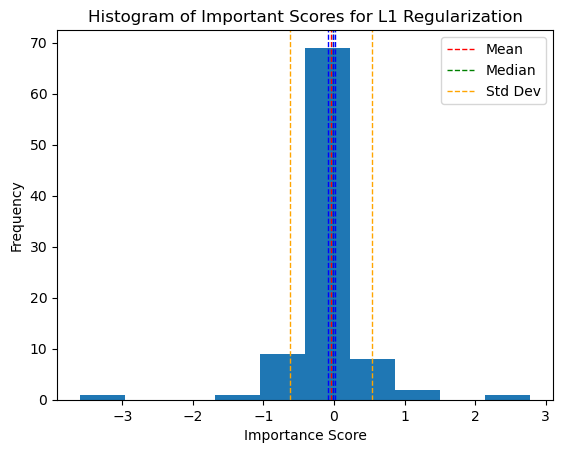

In [83]:
import matplotlib.pyplot as plt

# Plot histogram of important scores for L1 regularization
plt.hist(df_embeded_lr_scores['Score'])
plt.xlabel('Importance Score')
plt.ylabel('Frequency')
plt.title('Histogram of Important Scores for L1 Regularization')

# Display mean, median, and standard deviation details
plt.axvline(mean_score_l1, color='red', linestyle='dashed', linewidth=1)
plt.axvline(median_score_l1, color='green', linestyle='dashed', linewidth=1)
plt.axvline(mean_score_l1 + std_score_l1, color='orange', linestyle='dashed', linewidth=1)
plt.axvline(mean_score_l1 - std_score_l1, color='orange', linestyle='dashed', linewidth=1)
plt.legend({'Mean':mean_score_l1,'Median':median_score_l1,'Std Dev':std_score_l1})

#Calculate and plot quartiles
quartiles = np.quantile(df_embeded_lr_scores['Score'], [0, 0.25, 0.5, 0.75, 1])
plt.axvline(quartiles[1], color='blue', linestyle='dashed', linewidth=1)
plt.axvline(quartiles[2], color='blue', linestyle='dashed', linewidth=1)
plt.axvline(quartiles[3], color='blue', linestyle='dashed', linewidth=1)

plt.show()


In [7]:
# Calculate counts and percentages of variables above and below mean score
above_mean = df_embeded_lr_scores[df_embeded_lr_scores['Score'] > mean_score_l1]
below_mean = df_embeded_lr_scores[df_embeded_lr_scores['Score'] <= mean_score_l1]

above_mean_count = len(above_mean)
below_mean_count = len(below_mean)

total_count = len(df_embeded_lr_scores)

above_mean_perc = above_mean_count / total_count * 100
below_mean_perc = below_mean_count / total_count * 100

# Print counts and percentages
print(f'Variables above mean score: {above_mean_count} ({above_mean_perc:.2f}%)')
print(f'Variables below mean score: {below_mean_count} ({below_mean_perc:.2f}%)')

# Print the features
print('\nVariables above mean score:')
print(above_mean['Variable'])
print('\nVariables below mean score:')
print(below_mean['Variable'])


In [8]:
# Calculate and print counts and percentages of variables in each quartile
for i, quartile in enumerate(quartiles):
    if i == 0:
        continue
    variables = df_embeded_lr_scores[df_embeded_lr_scores['Score'] >= quartiles[i-1]]
    variables = variables[variables['Score'] <= quartile]
    count = len(variables)
    percent = count / len(df_embeded_lr_scores) * 100
    print(f"Quartile {i}: {count} ({percent:.2f}%) Variables")

    # Print names of variables in current quartile
    print("\tVariable Names:")
    for var in variables['Variable']:
        print(f"\t{var}")


In [9]:
df_rankings4.sort_values(by='Score', ascending=False)

In [35]:
above_median_lasso=df_rankings4[df_rankings4["Score"]>=df_rankings4["Score"].median()].sort_values(by='Score', ascending=False)

In [10]:
above_mean_lasso=df_rankings4[df_rankings4["Score"]>=df_rankings4["Score"].mean()].sort_values(by='Score', ascending=False)


In [36]:
df_rankings4 = df_rankings4.rename(columns={'Score': 'Score_lasso'})


### Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# Compute feature importances
importances = clf.feature_importances_
feature_names = X.columns

# Create a DataFrame with feature names and importances
rfe_importances = pd.DataFrame({'Variable': feature_names, 'Score': importances})

# Use RFE to select the top 46 features
rfe_selector = RFE(estimator=clf, n_features_to_select=91, step=10, verbose=5)
rfe_selector.fit(X, y)

# Get the accuracy of the classifier on the test set
accuracy_s = accuracy_score(rfe_selector.predict(X_test), y_test)

# Get the names of the selected features
rfe_support = rfe_selector.get_support()
mean_score_rf = np.mean(rfe_importances['Score'])
median_score_rf = np.median(rfe_importances['Score'])
std_score_rf = np.std(rfe_importances['Score'])
min_score_rf = np.min(rfe_importances['Score'])
max_score_rf = np.max(rfe_importances['Score'])

# Rank the variables based on their mean important score in descending order
df_rankings5 = rfe_importances.sort_values(by='Score', ascending=False)

# Print the results
print("Accuracy:", accuracy_s)
print("Selected features:", feature_names[rfe_support])
print("Mean importance score:", mean_score_rf)
print("Median importance score:", median_score_rf)
print("Standard deviation of importance scores:", std_score_rf)
print("Minimum importance score:", min_score_rf)
print("Maximum importance score:", max_score_rf)
print("Rankings of selected features:")
print(df_rankings5)


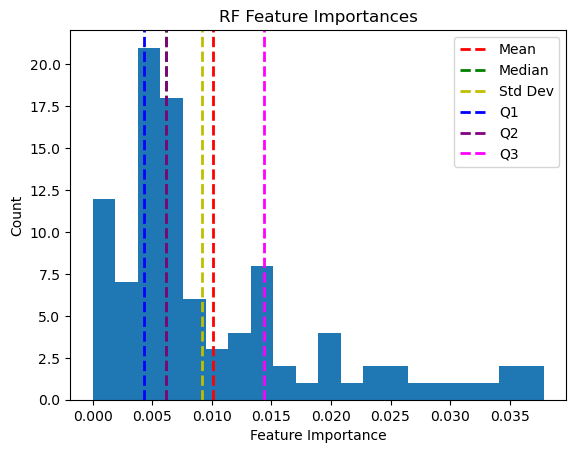

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Plot a histogram of RFE feature importances
plt.hist(rfe_importances['Score'], bins=20)
plt.xlabel('Feature Importance')
plt.ylabel('Count')
plt.title('RF Feature Importances')

# Calculate and plot the mean, median, and standard deviation of feature importances
mean_score_rf = np.mean(rfe_importances['Score'])
median_score_rf = np.median(rfe_importances['Score'])
std_score_rf = np.std(rfe_importances['Score'])
plt.axvline(x=mean_score_rf, color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(x=median_score_rf, color='g', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(x=std_score_rf, color='y', linestyle='dashed', linewidth=2, label='Std Dev')

# Calculate and plot quartiles
quartiles = np.quantile(rfe_importances['Score'], [0, 0.25, 0.5, 0.75, 1])
plt.axvline(quartiles[1], color='b', linestyle='dashed', linewidth=2, label='Q1')
plt.axvline(quartiles[2], color='purple', linestyle='dashed', linewidth=2, label='Q2')
plt.axvline(quartiles[3], color='magenta', linestyle='dashed', linewidth=2, label='Q3')

# Show legend
plt.legend()

# Show the plot
plt.show()



In [12]:
# Count and percentage of features above the mean
above_mean = rfe_importances[rfe_importances['Score'] > mean_score_rf]
num_above_mean = len(above_mean)
percent_above_mean = num_above_mean / len(rfe_importances) * 100

print(f"Number of features above mean: {num_above_mean} ({percent_above_mean:.2f}%)")
print("Features above mean:", above_mean['Variable'].tolist())

# Count and percentage of features below the mean
below_mean = rfe_importances[rfe_importances['Score'] < mean_score_rf]
num_below_mean = len(below_mean)
percent_below_mean = num_below_mean / len(rfe_importances) * 100

print(f"Number of features below mean: {num_below_mean} ({percent_below_mean:.2f}%)")
print("Features below mean:", below_mean['Variable'].tolist())


In [41]:
above_median_RandomForest=df_rankings5[df_rankings5["Score"]>=df_rankings5["Score"].median()].sort_values(by='Score', ascending=False)

In [13]:
above_mean_rf= df_rankings5[df_rankings5["Score"]>=df_rankings5["Score"].mean()].sort_values(by='Score', ascending=False)

In [42]:
df_rankings5 = df_rankings5.rename(columns={'Score': 'Score_RF'})


## Genetic

In [14]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from genetic_selection import GeneticSelectionCV


# Define the estimator and the genetic feature selection algorithm
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
selector = GeneticSelectionCV(
    estimator,
    cv=5,
    verbose=1,
    scoring="neg_mean_squared_error",
    max_features= 90,
    n_population=100,
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_generations=50,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.04,
    tournament_size=3,
    n_gen_no_change=10,
    caching=True,
    n_jobs=-1
)

# Fit the genetic feature selection algorithm on the training data
selector = selector.fit(X_train, y_train)

# Print the selected features
selected_features = X.columns[selector.support_]
print('Selected Features:', selected_features)

# Calculate the important scores for each feature
importances = selector.estimator_.feature_importances_
df_importances = pd.DataFrame({'Feature': X.columns, 'Score_genf': importances})

# Calculate the mean, median, standard deviation, minimum, and maximum importance score for each feature
mean_score = df_importances['Score_genf'].mean()
median_score = df_importances['Score_genf'].median()
std_score = df_importances['Score_genf'].std()
min_score = df_importances['Score_genf'].min()
max_score = df_importances['Score_genf'].max()

# Print the statistics for important scores
print(f"Mean importance score: {mean_score}")
print(f"Median importance score: {median_score}")
print(f"Standard deviation of importance score: {std_score}")
print(f"Minimum importance score: {min_score}")
print(f"Maximum importance score: {max_score}")

# Rank the features based on their mean importance score in descending order
df_rankings6 = df_importances6.sort_values(by='Score_genf', ascending=False)
print(df_rankings6)


In [ ]:

estimator = DecisionTreeClassifier()
model = GeneticSelectionCV(estimator, cv = 5, verbose = 0, scoring  = "accuracy", max_features = 90,
                           n_population = 100, crossover_proba = 0.5, mutation_proba = 0.2, n_generations = 50,
                           crossover_independent_proba = 0.5, mutation_independent_proba = 0.04,
                           tournament_size = 3, n_gen_no_change = 20, caching = True, n_jobs = -1)
gen_support = model.fit(X_train, y_train)
# Print the selected features
selected_features = X.columns[selector.support_]
print('Selected Features:', selected_features)


In [93]:
#merged_table = df_rankings.merge(df_rankings1, on='Variable').merge(df_rankings3, on='Variable').merge(df_rankings4, on='Variable').merge(df_rankings5, on='Variable')


# Select features based on median 

In [45]:
cols=df.columns.tolist()
col=['Variable']
all_col= pd.DataFrame(cols, columns= col)

In [51]:
merged_table_median =all_col.merge(above_median_chi, on = 'Variable', how= 'left').merge(above_median_rfe, on='Variable', how='left').merge(above_median_lasso, on='Variable', how='left').merge(above_median_RandomForest, on='Variable', how='left')


In [52]:
merged_table_median.iloc[:,1:]=merged_table_median.iloc[:,1:].notna().astype('int')


In [53]:
#merged_table_median
merged_table_median['Total']=np.sum(merged_table_median, axis=1)


In [15]:
merged_table_median=merged_table_median.sort_values(by='Total', ascending= False)

In [56]:
#by referring to the excel sheet of results we find 34 features were selected by at least 3/4 classifiers
#thus we select and store those top 50 in selected_features_az_top
selected_features_az_top=list(merged_table_median['Variable'][:34])


In [112]:
# Add demographic features to selected features
demographics=[ 'FEMALE', 'ZIPINC_QRTL', 'AGE']
selected_features_az_top.extend(demographics)